## Landsat (https://landsat.gsfc.nasa.gov/)
- USGS (미국 지질조사국)과 NASA (미항공우주국)에서 공동개발한 지구관측위성
- 1972년 7월 23일 "Earth Resources Technology Satellite" 이라는 이름으로 시작하여 현재는 Landsat으로 바뀌었음
- 2013년 2월 11일 발사된 Landsat8과 2021년 9월 27일에 발사된 지구관측 위성이 현재 운용되고 있는 위성
- Landsat 데이터의 응용 분야
    - Land use/Land cover
    - Agricultural management
    - Fish and Wildlife science
    - Forest science
    - watershed management
    - Climage science/change
    - Energy/minerals development
    - Defense/national security
    - Urban planning and development
    - Cultual resource management
    - Education
    - Emergency/disaster management

- Landsat Collections -https://developers.google.com/earth-engine/datasets/catalog/landsat

### 데이터 획득은 구글 클라우드를 통해서 가능

- google cloud 데이터 설명 -> https://cloud.google.com/storage/docs/public-datasets/landsat?hl=ko
- google 클라우드에서 다음 자료가 서비스되고 있음 (USGS 및 NASA의 개방 데이터 정책 덕분에 이 데이터세트는 Google Public Cloud Data 프로그램의 일부로 무료 제공)  
        Landsat 4: 1982 - 1993  
        Landsat 5: 1984 - 2013  
        Landsat 7: 1999 - 2021  
        Landsat 8: 2013 - 2021  
- 이미지는 GeoTIFF 파일 형식으로 저장되며 간편한 액세스를 위해 각 스펙트럼 대역이 개별 파일에 저장되어 있음
- 디렉토리 구조
    /SENSOR_ID/01/PATH/ROW/SCENE_ID/
        SENSOR_ID: 특정 위성과 카메라 센서의 식별자
        01: Landsat Collection 1의 일부인 데이터의 식별자
        PATH: WRS 경로 번호
        ROW: WRS 행 번호
        SCENE_ID: 고유 장면 ID

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [90]:
!pip install folium

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip uninstall shapely
!pip install shapely --no-binary shapely

!pip install rasterio
!pip install imagecodecs

     |████████████████████████████████| 102 kB 349 kB/s ta 0:00:01


## Data read

In [66]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from affine import Affine
from pyproj import Proj, transform
from skimage import io

In [35]:
path = '/content/drive/MyDrive/Colab Notebooks/'
fname = path+ 'LC09_L1TP_115035_20230508_20230508_02_T1_refl.tif'

In [47]:
with rasterio.open(fname) as r:
    T0 = r.transform  # upper-left pixel corner affine transform
    p1 = Proj(r.crs)
    A = r.read()  # pixel values
print(fname)
# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

LC09_L1TP_115035_20230508_20230508_02_T1_refl.tif


In [37]:
cols.shape, rows.shape

((7881, 7761), (7881, 7761))

In [45]:
T1 = T0 * Affine.translation(0.5, 0.5)
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

# All eastings and northings (there is probably a faster way to do this)
eastings, northings = np.vectorize(rc2en, otypes=[float, float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
longs, lats = transform(p1, p2, eastings, northings)
print(longs.shape, lats.shape)

/scratch/q593a01/.conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  This is separate from the ipykernel package so we can avoid doing imports until
/scratch/q593a01/.conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


(7881, 7761) (7881, 7761)


In [48]:
dim1, dim2, dim3 =  A.shape
print(dim1, dim2, dim3)

3 7881 7761


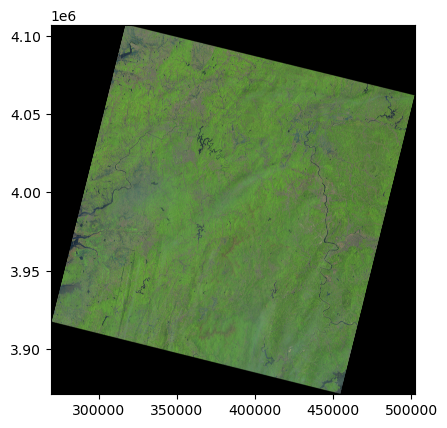

<AxesSubplot:>

In [77]:
with rasterio.open(fname) as img :
    imgnp= img.read()
    imgmeta=img.meta
show(imgnp)

In [ ]:
plt.hist(imgnp[0,:,:].flatten(),bins=100, label = 'CH1')
plt.hist(imgnp[1,:,:].flatten(),bins=100, label = 'CH2')
plt.hist(imgnp[2,:,:].flatten(),bins=100, label = 'CH3')
plt.xlim(20,170)
plt.ylim(0,0.6e7)
plt.legend()

In [93]:
import folium

In [ ]:
phone_map = folium.Map()

# Top three smart phone companies by market share in 2016
companies = [
    {'loc': [37.4970,  127.0266], 'label': 'Samsung: ...%'},
    {'loc': [37.3318, -122.0311], 'label': 'Apple: ...%'},
    {'loc': [22.5431,  114.0579], 'label': 'Huawei: ...%'}] 

# Adding markers to the map
for company in companies:
    marker = folium.Marker(location=company['loc'], popup=company['label'])
    marker.add_to(phone_map)

# The last object in the cell always gets shown in the notebook
phone_map

In [115]:
A_trans = np.transpose(A, (1,2,0))
A_trans.shape

(7881, 7761, 3)

In [120]:
m = folium.Map(tiles='stamenterrain',location=[lats.mean(), longs.mean()], zoom_start=4, crs='EPSG3857')
folium.raster_layers.ImageOverlay(A_trans,
                     [[lats.min(), longs.min()], [lats.max(), longs.max()]],
                     opacity=0.6).add_to(m)

In [ ]:
m.save('landsatmap.html')

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [122]:
def pcolormesh(lon, lat, data, var, unit, projection, size, cmap, mindata, maxdata, minlon, maxlon, minlat, maxlat):
    fig = plt.figure(figsize=size)
    ax = plt.axes(projection=projection)
    data= np.where(data==0, np.nan, data)
    #data = data*0.00341802+149.0
    print(np.nanmin(data), np.nanmax(data))
    cf1 = ax.pcolormesh(lon, lat, data, cmap=cmap, transform=ccrs.PlateCarree(), vmin=mindata, vmax=maxdata)
    
    ax.coastlines('50m')
    #ax.set_global()
    ax.set_extent([minlon, maxlon, minlat, maxlat])
    ax.set_title(var, size='xx-large')

    cbar = plt.colorbar(cf1, orientation='horizontal', 
                        pad=0.05,shrink=0.8) 
    cbar.set_label(unit, size='x-large')

    gl=ax.gridlines(draw_labels=True,x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    plt.show()

In [ ]:
pcolormesh(longs, lats, A_2d,'LandSAT L1GT', #('+flist[0][-16:-4]+')', 
           'K', ccrs.PlateCarree(), (10,10), plt.get_cmap('gray'), 1, 255, 124, 131, 33,39)

## Landsat Land Surfacetemperature

In [133]:
from affine import Affine
from pyproj import Proj, transform

In [149]:
fname = path+ 'LC08_L2SP_115034_20210102_20210308_02_T1_ST_B10.TIF'

with rasterio.open(fname) as r:
    T0 = r.transform  # upper-left pixel corner affine transform
    p1 = Proj(r.crs)
    A = r.read()  # pixel values
print(fname, p1)
# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))
print(cols.shape, rows.shape)

/scratch/q593a05/NMSC/LANDSAT/landsat_ot_c2_l2/2021/01/02_08/LC08_L2SP_115034_20210102_20210308_02_T1/LC08_L2SP_115034_20210102_20210308_02_T1_ST_B10.TIF proj=utm zone=52 datum=WGS84 units=m no_defs ellps=WGS84 towgs84=0,0,0
(7891, 7761) (7891, 7761)


In [146]:
T1 = T0 * Affine.translation(0.5, 0.5)
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

# All eastings and northings (there is probably a faster way to do this)
eastings1, northings1 = np.vectorize(rc2en, otypes=[float, float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
longs, lats = transform(p1, p2, eastings1, northings1)

/scratch/q593a01/.conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  This is separate from the ipykernel package so we can avoid doing imports until
/scratch/q593a01/.conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.


(1, 7891, 7761)
149.0 310.23483944


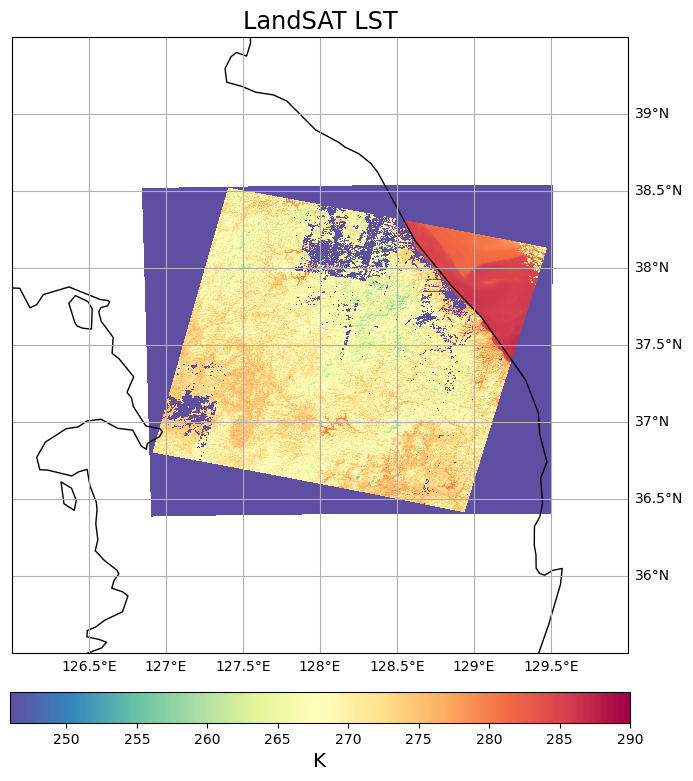

In [152]:
np.unique(A, return_counts = True)
A_re = A*0.00341802+149.0
print(A.shape)
pcolormesh(longs, lats, np.squeeze(A_re),'LandSAT LST', #('+flist[0][-16:-4]+')', 
           'K', ccrs.PlateCarree(), (10,10), plt.get_cmap('Spectral_r'), 246, 290,126,130,35.5,39.5)

149.0 310.23483944


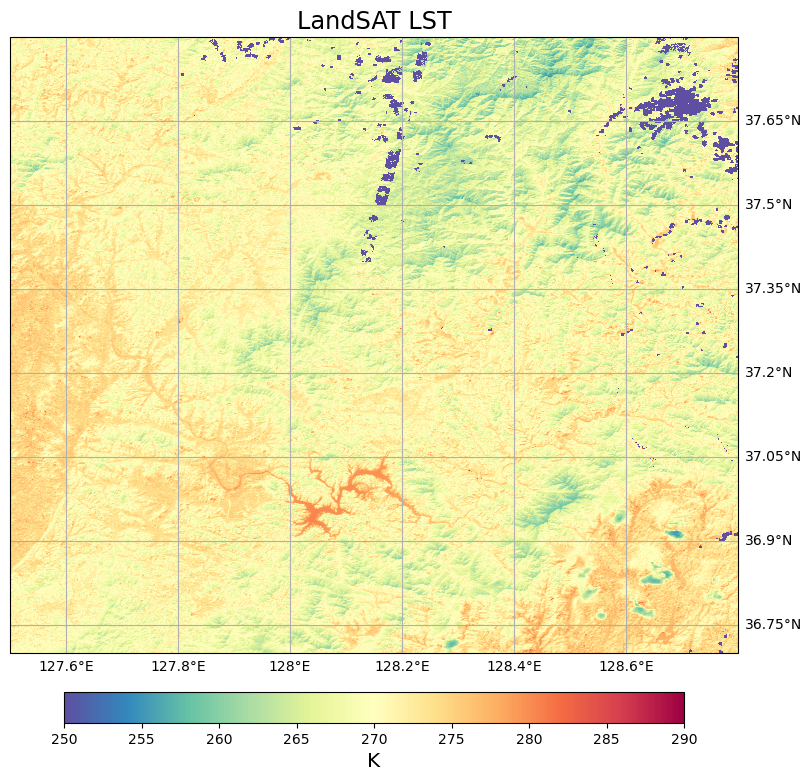

In [154]:
pcolormesh(longs, lats, np.squeeze(A_re),'LandSAT LST', #('+flist[0][-16:-4]+')', 
           'K', ccrs.PlateCarree(), (10,10), plt.get_cmap('Spectral_r'), 250, 290,127.5,128.8,36.7,37.8)